<a href="https://colab.research.google.com/github/DJCordhose/ai/blob/master/notebooks/2019_tf/time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series / Sequences

Links
* Example and a lot of imspiration taken from: https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/
* RNNs used for text: https://colab.research.google.com/github/djcordhose/ai/blob/master/notebooks/tensorflow/sentiment-gru-reg.ipynb

## Univariate Sequences

just one variable per time step

In [0]:
# univariate data preparation
import numpy as np

# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [2]:
# define input sequence
raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]

# choose a number of time steps
n_steps = 3

# split into samples
X, y = split_sequence(raw_seq, n_steps)

# summarize the data
list(zip(X, y))

[(array([10, 20, 30]), 40),
 (array([20, 30, 40]), 50),
 (array([30, 40, 50]), 60),
 (array([40, 50, 60]), 70),
 (array([50, 60, 70]), 80),
 (array([60, 70, 80]), 90)]

In [3]:
X

array([[10, 20, 30],
       [20, 30, 40],
       [30, 40, 50],
       [40, 50, 60],
       [50, 60, 70],
       [60, 70, 80]])

In [4]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
X

array([[[10],
        [20],
        [30]],

       [[20],
        [30],
        [40]],

       [[30],
        [40],
        [50]],

       [[40],
        [50],
        [60]],

       [[50],
        [60],
        [70]],

       [[60],
        [70],
        [80]]])

In [0]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, LSTM, GRU, SimpleRNN, Bidirectional
from tensorflow.keras.models import Sequential, Model

# define model
model = Sequential()
model.add(SimpleRNN(units=50, activation='relu', input_shape=(n_steps, n_features), name="RNN_Input"))
model.add(Dense(units=1, name="Linear_Output"))
model.compile(optimizer='adam', loss='mse')

In [6]:
# fit model
%time history = model.fit(X, y, epochs=500, verbose=0)

CPU times: user 1.58 s, sys: 49 ms, total: 1.63 s
Wall time: 1.29 s


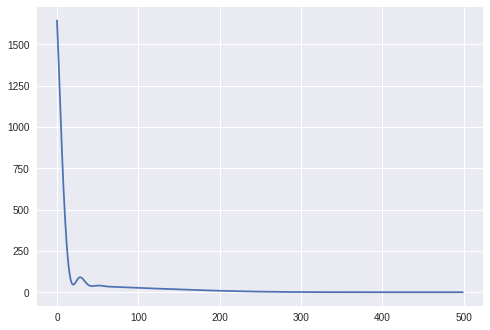

In [7]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])

In [8]:
# this does not look too bad
X_sample = np.array([[10, 20, 30], [70, 80, 90]])
X_sample = X_sample.reshape((X_sample.shape[0], X_sample.shape[1], n_features))
X_sample

array([[[10],
        [20],
        [30]],

       [[70],
        [80],
        [90]]])

In [9]:
y_pred = model.predict(X_sample)
y_pred

array([[ 39.955833],
       [100.00681 ]], dtype=float32)

In [0]:
def predict(model, samples, n_features=1):
  input = np.array(samples)
  input = input.reshape((input.shape[0], input.shape[1], n_features))
  y_pred = model.predict(input)
  return y_pred

In [11]:
# do not look too close, though
predict(model, [[100, 110, 120], [200, 210, 220], [200, 300, 400]])

array([[130.28812],
       [231.22566],
       [489.44513]], dtype=float32)

## Multi Layer RNNs

In [12]:
# what comes out of an RNN?
rnn_layer = model.get_layer("RNN_Input")
model_stub = Model(inputs = model.input, outputs = rnn_layer.output)
hidden = predict(model_stub, [[10, 20, 30]])
hidden

array([[0.0000000e+00, 0.0000000e+00, 6.6298933e+00, 4.3171320e+00,
        1.6152182e+01, 5.3424644e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 7.6165895e+00, 0.0000000e+00, 1.0835503e+01,
        2.4298921e+00, 0.0000000e+00, 8.1883535e+00, 1.9176640e+01,
        4.3059235e+00, 1.8545227e+00, 0.0000000e+00, 1.2883280e+01,
        0.0000000e+00, 0.0000000e+00, 2.1841927e+01, 0.0000000e+00,
        9.2021837e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        2.3887208e+00, 1.4606287e+01, 0.0000000e+00, 1.2817833e+01,
        1.1759097e+01, 9.9295425e+00, 1.5430450e-03, 0.0000000e+00,
        7.4177976e+00, 1.1161446e+01, 0.0000000e+00, 6.3729925e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 2.5042084e+01, 0.0000000e+00,
        7.5365171e+00, 0.0000000e+00]], dtype=float32)

### What's the issue?
* each unit (50) has a single output
* as a sidenote you nicely see the RELU nature of the output
* so the timesteps are lost
* we are only looking at the final output
* still with each timestep, the layer does produce a unique output we can use

## We need to look into RNNs a bit more deeply now

### RNNs - Networks with Loops
<img src='https://djcordhose.github.io/ai/img/nlp/colah/RNN-rolled.png' height=200>

http://colah.github.io/posts/2015-08-Understanding-LSTMs/
### Unrolling the loop
<img src='https://djcordhose.github.io/ai/img/nlp/colah/RNN-unrolled.png'>

http://colah.github.io/posts/2015-08-Understanding-LSTMs/
### Simple RNN internals

<img src='https://djcordhose.github.io/ai/img/nlp/fchollet_rnn.png'>

##  $output_t = \tanh(W input_t + U output_{t-1} + b)$

From Deep Learning with Python, Chapter 6, François Chollet, Manning: https://livebook.manning.com/#!/book/deep-learning-with-python/chapter-6/129

### Activation functions

<img src='https://djcordhose.github.io/ai/img/sigmoid-activation.png' height=200>

Sigmoid compressing between 0 and 1

<img src='https://djcordhose.github.io/ai/img/tanh-activation.png' height=200>

Hyperbolic tangent, like sigmoind, but compressing between -1 and 1, thus allowing for negative values as well

In [13]:
# https://arxiv.org/ftp/arxiv/papers/1701/1701.05923.pdf
# n = output dimension
# m = input dimension
# Total number of parameters for 
# Simple RNN = n**2 + nm + n
# GRU = 3 × (n**2 + nm + n)
# LSTM = 4 × (n**2 + nm + n)

rnn_units = 1

model = Sequential()
model.add(SimpleRNN(units=rnn_units, activation='relu', input_shape=(n_steps, n_features), name="RNN_Input"))
# model.add(GRU(units=rnn_units, activation='relu', input_shape=(n_steps, n_features), name="RNN_Input"))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
RNN_Input (SimpleRNN)        (None, 1)                 3         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


In [14]:
output_dimension = rnn_units
input_dimension = n_features
parameters = 1 * (output_dimension ** 2 +  output_dimension * input_dimension + output_dimension) 
parameters

3

In [15]:
# from only a single output for the final timestep
# ideal for feeding into something that *does not* handle timesteps
rnn_units = 1
model = Sequential([
    SimpleRNN(units=rnn_units, activation='relu', input_shape=(n_steps, n_features))
])
predict(model, [[10, 20, 30]])

array([[57.63228]], dtype=float32)

In [16]:
# to one output for each timestep
# ideal for feeding into something that *expects* timesteps
rnn_units = 1
model = Sequential([
    SimpleRNN(units=rnn_units, activation='relu', input_shape=(n_steps, n_features), return_sequences=True)
])
predict(model, [[10, 20, 30]])

array([[[15.802732],
        [15.802732],
        [31.605467]]], dtype=float32)

In [17]:
rnn_units = 50

model = Sequential([
    SimpleRNN(units=rnn_units, activation='relu', input_shape=(n_steps, n_features), return_sequences=True, name="RNN_Input"),
    SimpleRNN(units=rnn_units, activation='relu', name="RNN_Latent"),
    Dense(units=1, name="Linear_Output")
])
model.compile(optimizer='adam', loss='mse')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
RNN_Input (SimpleRNN)        (None, 3, 50)             2600      
_________________________________________________________________
RNN_Latent (SimpleRNN)       (None, 50)                5050      
_________________________________________________________________
Linear_Output (Dense)        (None, 1)                 51        
Total params: 7,701
Trainable params: 7,701
Non-trainable params: 0
_________________________________________________________________


CPU times: user 2.61 s, sys: 62.7 ms, total: 2.68 s
Wall time: 2.11 s


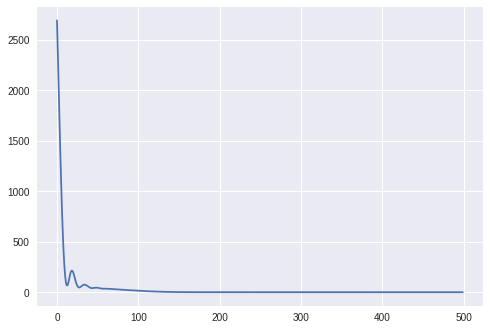

In [18]:
%time history = model.fit(X, y, epochs=500, verbose=0)
plt.plot(history.history['loss'])

In [19]:
predict(model, [[10, 20, 30], [70, 80, 90], [100, 110, 120], [200, 210, 220], [200, 300, 400]])

array([[ 39.94643],
       [100.40439],
       [131.7255 ],
       [236.95358],
       [494.70953]], dtype=float32)

## Bidirectional RNNs

In [0]:
rnn_units = 50

model = Sequential([
    Bidirectional(SimpleRNN(units=rnn_units, activation='relu', input_shape=(n_steps, n_features), name="RNN_Input")),
    Dense(units=1, name="Linear_Output")
])
model.compile(optimizer='adam', loss='mse')

CPU times: user 2.91 s, sys: 52.7 ms, total: 2.96 s
Wall time: 2.46 s


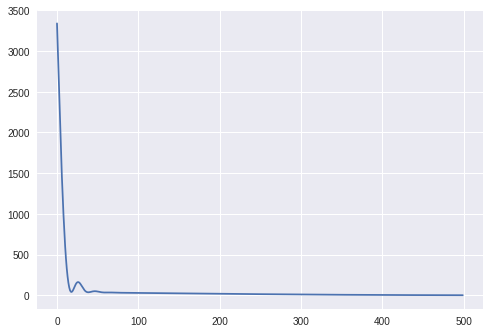

In [21]:
%time history = model.fit(X, y, epochs=500, verbose=0)
plt.plot(history.history['loss'])

In [22]:
predict(model, [[10, 20, 30], [70, 80, 90], [100, 110, 120], [200, 210, 220], [200, 300, 400]])

array([[ 38.731518],
       [101.06814 ],
       [134.25352 ],
       [244.93915 ],
       [480.1645  ]], dtype=float32)

## LSMTs / GRUs

* mainly beneficial for long sequences
* but also 3-4 times more expensive
* might not have better results for short sequences like these

In [23]:
rnn_units = 50

model = Sequential([
    LSTM(units=rnn_units, activation='relu', input_shape=(n_steps, n_features), name="RNN_Input"),
    Dense(units=1, name="Linear_Output")
])
model.compile(optimizer='adam', loss='mse')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
RNN_Input (LSTM)             (None, 50)                10400     
_________________________________________________________________
Linear_Output (Dense)        (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [26]:
output_dimension = rnn_units
input_dimension = n_features
parameters = 4 * (output_dimension ** 2 +  output_dimension * input_dimension + output_dimension) 
parameters

10400

CPU times: user 10.8 s, sys: 421 ms, total: 11.2 s
Wall time: 6.51 s


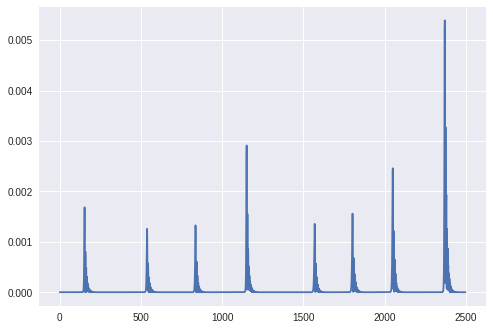

In [36]:
%time history = model.fit(X, y, epochs=500, verbose=0)
plt.plot(history.history['loss'])

In [37]:
predict(model, [[10, 20, 30], [70, 80, 90], [100, 110, 120], [200, 210, 220], [200, 300, 400]])

array([[ 40.00004],
       [101.56426],
       [136.431  ],
       [253.01685],
       [405.13403]], dtype=float32)

In [38]:
rnn_units = 50

model = Sequential([
    GRU(units=rnn_units, activation='relu', input_shape=(n_steps, n_features), name="RNN_Input"),
    Dense(units=1, name="Linear_Output")
])
model.compile(optimizer='adam', loss='mse')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
RNN_Input (GRU)              (None, 50)                7800      
_________________________________________________________________
Linear_Output (Dense)        (None, 1)                 51        
Total params: 7,851
Trainable params: 7,851
Non-trainable params: 0
_________________________________________________________________


In [39]:
output_dimension = rnn_units
input_dimension = n_features
parameters = 3 * (output_dimension ** 2 +  output_dimension * input_dimension + output_dimension) 
parameters

7800

CPU times: user 2.1 s, sys: 132 ms, total: 2.23 s
Wall time: 1.31 s


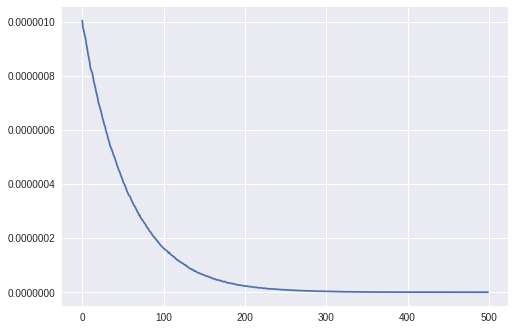

In [42]:
%time history = model.fit(X, y, epochs=500, verbose=0)
plt.plot(history.history['loss'])

In [43]:
predict(model, [[10, 20, 30], [70, 80, 90], [100, 110, 120], [200, 210, 220], [200, 300, 400]])

array([[ 39.999996],
       [103.0071  ],
       [141.9554  ],
       [270.7792  ],
       [374.36    ]], dtype=float32)